## Multiclass Classification

In [75]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

Initialize the variable

In [76]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

Starter functions for the AutoML model

In [77]:
def alphabet(n):
    alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
    str=''
    r=len(alpha)-1   
    while len(str)<n:
        i=random.randint(0,r)
        str+=alpha[i]   
    return str

def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
    m_data={}
    m_data['run_id'] =run_id
    m_data['start_time'] = time.time()
    m_data['target']=target
    m_data['max_models']=model
    m_data['run_time']=run_time
    m_data['scale']=scale
    m_data['classification']=classification
    m_data['scale']=False
    m_data['balance']=balance
    m_data['balance_threshold']=balance_threshold
    m_data['project'] =name
    m_data['end_time'] = time.time()
    m_data['execution_time'] = 0.0
    m_data['nthreads'] = nthreads
    m_data['min_mem_size'] = min_mem_size
    m_data['analysis'] = analysis
    return m_data

def dict_to_json(dct,n):
    j = json.dumps(dct, indent=4)
    f = open(n, 'w')
    print(j, file=f)
    f.close()
    
def stackedensemble(mod):
    coef_norm=None
    try:
        metalearner = h2o.get_model(mod.metalearner()['name'])
        coef_norm=metalearner.coef_norm()
    except:
        pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
        if len(row['model_id'])>3:
            key=row['model_id'][0:3]
            if key in bm_algo:
                if bm_algo[key] is None:
                    bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d

def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

def model_performance_stats(perf):
    d={}
    try:    
        d['mse']=perf.mse()
    except:
        pass      
    try:    
        d['rmse']=perf.rmse() 
    except:
        pass      
    try:    
        d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
        pass      
    try:    
        d['residual_deviance']=perf.residual_deviance() 
    except:
        pass      
    try:    
        d['null_deviance']=perf.null_deviance() 
    except:
        pass      
    try:    
        d['aic']=perf.aic() 
    except:
        pass      
    try:
        d['logloss']=perf.logloss() 
    except:
        pass    
    try:
        d['auc']=perf.auc()
    except:
        pass  
    try:
        d['gini']=perf.gini()
    except:
        pass    
    return d

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
        iv = pd.read_csv(i,header=None)
    except:
        sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
        ivd[c.strip()]=dt[i].strip()
        i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
            if dct[key] not in ['real','int','enum']:                      
                targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
            if dct[key] != val:
                print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                    df[key] = df[key].asfactor() 
                except:
                    targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                    df[key] = df[key].asnumeric() 
                except:
                    targ.remove(key)                  
            if dct[key]=='real':
                try:                
                    df[key] = df[key].asnumeric()  
                except:
                    targ.remove(key)                  
    if y is None:
        y=df.columns[-1] 
    if y in targ:
        targ.remove(y)
    else:
        y=targ.pop()            
    return targ

def check_X(x,df):
    for name in x:
        if name not in df.columns:
            x.remove(name)  
    return x 

def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
        if 'BestOfFamily' in model:
            se=model
        if se is None:     
            for model in model_set:
                if 'AllModels'in model:
                    se=model           
    return se 

def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d 

Add column headers to the dataset

In [78]:
data_path= 'car.csv'

In [79]:
df=pd.read_csv(data_path)

In [80]:
df.columns=['buying','maint','doors','persons','lug_boot','safety','class']

In [81]:
df.to_csv("car_clean.csv")

In [82]:
data_path="car_clean.csv"

In [83]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [84]:
all_variables=None

Create a directory to store all the results

In [85]:
run_id=alphabet(9)
# run_id to std out
print (run_id)

rY5hrHhNl


In [86]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)

Initialize H2O and import the data

In [87]:
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=6,port=port_no)

Checking whether there is an H2O instance running at http://localhost:33958..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.141-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\raksh\AppData\Local\Temp\tmpkrc5lpg1
  JVM stdout: C:\Users\raksh\AppData\Local\Temp\tmpkrc5lpg1\h2o_raksha_started_from_python.out
  JVM stderr: C:\Users\raksh\AppData\Local\Temp\tmpkrc5lpg1\h2o_raksha_started_from_python.err
  Server is running at http://127.0.0.1:33958
Connecting to H2O server at http://127.0.0.1:33958... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_raksha_6i4pyj
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [88]:
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)

{'run_id': 'rY5hrHhNl', 'start_time': 1539722312.2699974, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1539722312.2699974, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [89]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [90]:
df.describe()

Rows:1727
Cols:8




,C1,buying,maint,doors,persons,lug_boot,safety,class
type,int,enum,enum,int,int,enum,enum,enum
mins,0.0,,,2.0,2.0,,,
mean,863.0,,,3.0007722007722,3.0008688097306666,,,
maxs,1726.0,,,4.0,4.0,,,
sigma,498.6862741243236,,,0.8166539469613198,1.0004343105525066,,,
zeros,1,,,0,0,,,
missing,0,0,0,432,576,0,0,0
0,0.0,vhigh,vhigh,2.0,2.0,small,med,unacc
1,1.0,vhigh,vhigh,2.0,2.0,small,high,unacc
2,2.0,vhigh,vhigh,2.0,2.0,med,low,unacc


In [91]:
y='class'

In [92]:
print(all_variables)

None


Check and impute the missing values

In [93]:
X = []  
if all_variables is None:
    X=get_independent_variables(df, y)  
else: 
    ivd=get_all_variables_csv(all_variables)    
    X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [94]:
df[y] = df[y].asfactor()

In [95]:
def check_y(y,df):
    ok=False
    C = [name for name in df.columns if name == y]
    for key, val in df.types.items():
        if key in C:
            if val in ['real','int','enum']:        
                ok=True         
    return ok, val

In [96]:
ok,val=check_y(y,df)

In [97]:
ok

True

In [98]:
val

'enum'

In [99]:
if val=='enum':
    print(df[y].levels())

[['acc', 'good', 'unacc', 'vgood']]


In [100]:
allV=get_variables_types(df)
allV

{'C1': 'int',
 'buying': 'enum',
 'maint': 'enum',
 'doors': 'int',
 'persons': 'int',
 'lug_boot': 'enum',
 'safety': 'enum',
 'class': 'enum'}

In [101]:
meta_data['variables']=allV

Split the dataframe into train and test and train the AutoML model

In [102]:
train, test = df.split_frame([0.9])

In [103]:
aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [104]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [105]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [106]:
aml_leaderboard_df

,model_id,mean_per_class_error,logloss,rmse,mse
0,GBM_grid_0_AutoML_20181016_163834_model_4,0.069628,0.088664,0.161820,0.026186
1,GBM_grid_0_AutoML_20181016_163834_model_15,0.074684,0.077306,0.154214,0.023782
2,GBM_grid_0_AutoML_20181016_163834_model_29,0.075647,0.080587,0.157806,0.024903
3,GBM_grid_0_AutoML_20181016_163834_model_20,0.079460,0.076665,0.143319,0.020540
4,GBM_grid_0_AutoML_20181016_163834_model_24,0.079799,0.067735,0.143651,0.020636
5,GBM_grid_0_AutoML_20181016_163834_model_3,0.083010,0.074586,0.153693,0.023622
6,StackedEnsemble_AllModels_0_AutoML_20181016_163834,0.083403,0.089778,0.153544,0.023576
7,StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834,0.091417,0.100942,0.167275,0.027981
8,GBM_grid_0_AutoML_20181016_163834_model_23,0.093816,0.117848,0.179147,0.032094
9,GBM_grid_0_AutoML_20181016_163834_model_18,0.094095,0.080581,0.156603,0.024525


In [107]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

StackedEnsemble is the best model for this dataset

In [108]:
mod_best._id

'GBM_grid_0_AutoML_20181016_163834_model_4'

In [109]:
se=get_stacked_ensemble(model_set)

In [110]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834


In [111]:
if se is not None:
    mod_best=h2o.get_model(se)

In [112]:
mod_best

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0015683018626747784
RMSE: 0.03960179115488059

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.03437179772724187
RMSE: 0.1853963260888464

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0279809091695698
RMSE: 0.16727495081323385


In [113]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834
No model summary for this model


ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0015683018626747784
RMSE: 0.03960179115488059

ModelMetricsMultinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.03437179772724187
RMSE: 0.1853963260888464

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0279809091695698
RMSE: 0.16727495081323385
<bound method ModelBase.coef_norm of >


In [114]:
bm=stackedensemble_df(aml_leaderboard_df)

In [115]:
bm

['GBM_grid_0_AutoML_20181016_163834_model_4',
 'GLM_grid_0_AutoML_20181016_163834_model_0',
 'DRF_0_AutoML_20181016_163834',
 'XRT_0_AutoML_20181016_163834',
 'DeepLearning_0_AutoML_20181016_163834']

In [116]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
    if 'Intercept' in best_models.keys():
        del best_models['Intercept']
    bm=list(best_models.keys())
else:
    best_models={}
    bm=stackedensemble_df(aml_leaderboard_df)   
    for b in bm:   
        best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [117]:
aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [118]:
aml_leaderboard_df

,model_id,mean_per_class_error,logloss,rmse,mse
0,GBM_grid_0_AutoML_20181016_163834_model_4,0.069628,0.088664,0.161820,0.026186
7,StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834,0.091417,0.100942,0.167275,0.027981
27,DRF_0_AutoML_20181016_163834,0.142983,0.175493,0.225361,0.050788
32,GLM_grid_0_AutoML_20181016_163834_model_0,0.226875,0.282138,0.307562,0.094594
34,XRT_0_AutoML_20181016_163834,0.250659,0.264706,0.265640,0.070564
36,DeepLearning_0_AutoML_20181016_163834,0.402303,0.301699,0.315626,0.099620


In [119]:

# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [120]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_grid_0_AutoML_20181016_163834_model_4


In [121]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

GBM_grid_0_AutoML_20181016_163834_model_4
gbm


In [122]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [123]:
meta_data['models']=bm

In [124]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
    try:   
        m=h2o.get_model(mod) 
        h2o.save_model(m, path = models_path)
    except:    
        pass

In [125]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181016_163834_model_4', 'varimp': [('safety', 586.560791015625, 1.0, 0.35400462180641984), ('persons', 435.03448486328125, 0.7416699028075552, 0.26255457344859273), ('C1', 359.4259033203125, 0.6127683759733916, 0.21692283719139457), ('maint', 100.64899444580078, 0.17159175312677805, 0.06074427367074563), ('buying', 77.00688934326172, 0.13128543626300856, 0.04647565121297718), ('lug_boot', 72.73973083496094, 0.12401055772755065, 0.04390031058834476), ('doors', 25.51296043395996, 0.04349585042973037, 0.015397732081525305)]}


In [126]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)

In [127]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass

{'algo': 'deeplearning', 'model_id': 'DeepLearning_0_AutoML_20181016_163834', 'varimp': [('safety.low', 1.0, 1.0, 0.10706584270870913), ('safety.med', 0.6995736360549927, 0.6995736360549927, 0.07490044088102357), ('persons', 0.6633797287940979, 0.6633797287940979, 0.071025309699215), ('maint.vhigh', 0.6202352046966553, 0.6202352046966553, 0.0664060048684561), ('maint.low', 0.6139724850654602, 0.6139724850654602, 0.06573548151349383), ('safety.high', 0.5517079830169678, 0.5517079830169678, 0.05906908013083383), ('lug_boot.small', 0.5169445872306824, 0.5169445872306824, 0.0553471078655588), ('buying.vhigh', 0.512730062007904, 0.512730062007904, 0.05489587617096493), ('buying.high', 0.5098448991775513, 0.5098448991775513, 0.05458697378118137), ('lug_boot.med', 0.5043025612831116, 0.5043025612831116, 0.05399357870393676), ('maint.high', 0.48341357707977295, 0.48341357707977295, 0.051757082006877404), ('C1', 0.48298379778862, 0.48298379778862, 0.05171106732489136), ('maint.med', 0.482173740

In [128]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
        stats_glm={}
        stats_glm=glm_stats(mod)
        n=run_id+'_glm_stats.json'
        dict_to_json(stats_glm,n)
        print(stats_glm)
    except:
         pass

### Prediction

In [129]:
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
        cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
        cf_df=cf[0].table.as_data_frame()
        cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
        pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [130]:
predictions = mod_best.predict(test)    
predictions_df=test.cbind(predictions).as_data_frame() 
predictions_df.to_csv(run_id+'_predictions.csv')

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [131]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [132]:
meta_data

{'run_id': 'rY5hrHhNl',
 'start_time': 1539722312.2699974,
 'target': None,
 'max_models': 9,
 'run_time': 333,
 'scale': False,
 'classification': False,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1539722860.407942,
 'execution_time': 548.1379446983337,
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'X': ['C1', 'doors', 'persons', 'buying', 'maint', 'lug_boot', 'safety'],
 'variables': {'C1': 'int',
  'buying': 'enum',
  'maint': 'enum',
  'doors': 'int',
  'persons': 'int',
  'lug_boot': 'enum',
  'safety': 'enum',
  'class': 'enum'},
 'model_execution_time': 544.5350785255432,
 'mod_best': 'GBM_grid_0_AutoML_20181016_163834_model_4',
 'mod_best_algo': 'gbm',
 'models': ['GBM_grid_0_AutoML_20181016_163834_model_4',
  'GLM_grid_0_AutoML_20181016_163834_model_0',
  'DRF_0_AutoML_20181016_163834',
  'XRT_0_AutoML_20181016_163834',
  'DeepLearning_0_AutoML_20181016_163834',
  'StackedEnsemble_BestOfFamily_0_AutoML_20181016_163834']}

### Plots

In [133]:
plots=aml.leaderboard

Variable Importance for deeplearning model

In [134]:
varImp=h2o.get_model(plots[1,"model_id"])

In [135]:
varImp.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,safety,1019.355286,1.000000,0.293340
1,persons,973.357117,0.954875,0.280103
2,C1,799.949646,0.784760,0.230201
3,maint,253.345184,0.248535,0.072905
4,lug_boot,187.853149,0.184286,0.054058
5,buying,172.765747,0.169485,0.049717
6,doors,68.372055,0.067074,0.019675


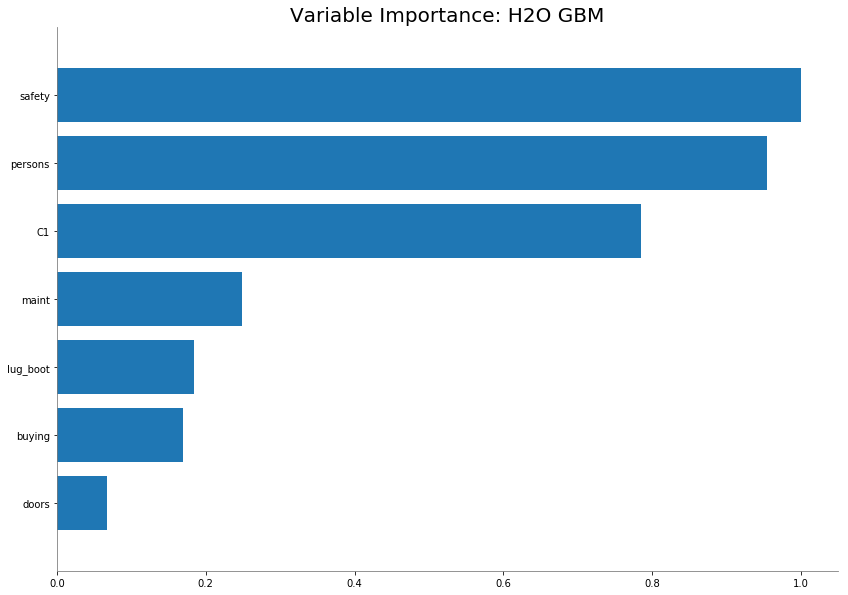

In [136]:
varImp.varimp_plot()

In [138]:
#varImp.partial_plot(data=df, cols=['doors','lug_boot','maint','buying','C1','persons','safety'], figsize=(30,30))

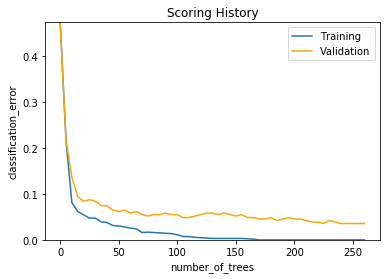

In [139]:
varImp.plot()

Confusion matrix

In [140]:
varImp.confusion_matrix

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_0_AutoML_20181016_163834_model_15


ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0012482636827887102
RMSE: 0.035330775292777124
LogLoss: 0.013938382891481256
Mean Per-Class Error: 0.0
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
275.0,0.0,0.0,0.0,0.0,0 / 275
0.0,56.0,0.0,0.0,0.0,0 / 56
0.0,0.0,877.0,0.0,0.0,0 / 877
0.0,0.0,0.0,40.0,0.0,0 / 40
275.0,56.0,877.0,40.0,0.0,"0 / 1,248"


Top-4 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0
4,1.0



ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.031095138547026408
RMSE: 0.17633813696142536
LogLoss: 0.10263342438951789
Mean Per-Class Error: 0.13916083916083916
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
66.0,0.0,0.0,0.0,0.0,0 / 66
0.0,10.0,0.0,0.0,0.0,0 / 10
3.0,1.0,216.0,0.0,0.0181818,4 / 220
3.0,4.0,0.0,6.0,0.5384615,7 / 13
72.0,15.0,216.0,6.0,0.0355987,11 / 309


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9644013
2,1.0
3,1.0
4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.023781817746072274
RMSE: 0.15421354592276346
LogLoss: 0.07730644443102547
Mean Per-Class Error: 0.07468372847221194
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
263.0,6.0,5.0,1.0,0.0436364,12 / 275
5.0,47.0,0.0,4.0,0.1607143,9 / 56
16.0,1.0,860.0,0.0,0.0193843,17 / 877
2.0,1.0,0.0,37.0,0.075,3 / 40
286.0,55.0,865.0,42.0,0.0328526,"41 / 1,248"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.9671474
2,0.9991987
3,0.9999999
4,0.9999999


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9671422,0.0110947,0.944,0.992,0.972,0.9678715,0.9598393
err,0.0328578,0.0110947,0.056,0.008,0.028,0.0321285,0.0401606
err_count,8.2,2.7712812,14.0,2.0,7.0,8.0,10.0
logloss,0.0773225,0.0188601,0.1106132,0.0315457,0.0697960,0.0803884,0.0942691
max_per_class_error,0.1922112,0.0628586,0.2727273,0.0344828,0.25,0.25,0.1538462
mean_per_class_accuracy,0.9260922,0.0239256,0.9089516,0.9913793,0.9213974,0.8943152,0.9144174
mean_per_class_error,0.0739078,0.0239256,0.0910484,0.0086207,0.0786025,0.1056848,0.0855826
mse,0.0237878,0.0065492,0.0354657,0.0083058,0.0200699,0.0252314,0.0298665
r2,0.9678698,0.0095872,0.9476488,0.9893163,0.9719781,0.9683018,0.962104
rmse,0.1505581,0.0236653,0.1883233,0.0911359,0.1416684,0.1588440,0.1728191


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-10-16 16:40:35,1 min 8.299 sec,0.0,0.75,1.3862944,0.4727564,0.75,1.3862944,0.4692557
,2018-10-16 16:40:35,1 min 8.330 sec,5.0,0.6483665,1.0522229,0.2147436,0.6544070,1.0710701,0.2168285
,2018-10-16 16:40:36,1 min 8.360 sec,10.0,0.5494332,0.8031455,0.0809295,0.5592295,0.8282903,0.1359223
,2018-10-16 16:40:36,1 min 8.393 sec,15.0,0.4659269,0.6263464,0.0616987,0.4767456,0.6503149,0.0938511
,2018-10-16 16:40:36,1 min 8.423 sec,20.0,0.4095219,0.5164981,0.0544872,0.4233477,0.5439133,0.0841424
---,---,---,---,---,---,---,---,---,---
,2018-10-16 16:40:37,1 min 9.647 sec,240.0,0.0418783,0.0170026,0.0,0.1759342,0.1023021,0.0355987
,2018-10-16 16:40:37,1 min 9.677 sec,245.0,0.0399149,0.0160636,0.0,0.1750878,0.1017722,0.0355987
,2018-10-16 16:40:37,1 min 9.706 sec,250.0,0.0383816,0.0153087,0.0,0.1746468,0.1014964,0.0355987
,2018-10-16 16:40:37,1 min 9.737 sec,255.0,0.0366198,0.0145446,0.0,0.1761572,0.1026029,0.0355987



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
safety,1019.3552856,1.0,0.2933398
persons,973.3571167,0.9548752,0.2801029
C1,799.9496460,0.7847604,0.2302015
maint,253.3451843,0.2485347,0.0729051
lug_boot,187.8531494,0.1842862,0.0540585
buying,172.7657471,0.1694853,0.0497168
doors,68.3720551,0.0670738,0.0196754


<bound method H2OMultinomialModel.confusion_matrix of >

In [141]:
roc=varImp.model_performance()
roc.show()


ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0012482636827887102
RMSE: 0.035330775292777124
LogLoss: 0.013938382891481256
Mean Per-Class Error: 0.0
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



acc,good,unacc,vgood,Error,Rate
275.0,0.0,0.0,0.0,0.0,0 / 275
0.0,56.0,0.0,0.0,0.0,0 / 56
0.0,0.0,877.0,0.0,0.0,0 / 877
0.0,0.0,0.0,40.0,0.0,0 / 40
275.0,56.0,877.0,40.0,0.0,"0 / 1,248"


Top-4 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0
4,1.0


In [142]:
os.chdir(server_path)

In [143]:
h2o.cluster().shutdown()

H2O session _sid_8d0f closed.
